In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as sig

In [31]:
def audio_matrix(path):
    fs_v = []
    audio_m = []

    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        
        
        y, sr = librosa.load(file_path, sr=None)

        fs_v.append(sr)
        audio_m.append(y)

    # Calcular la frecuencia de muestreo promedio
    fs = np.mean(fs_v)

    # Asegurarse de que todos los arreglos de audio tengan la misma longitud
    max_length = max(len(y) for y in audio_m)
    audio_m_padded = np.array([np.pad(y, (0, max_length - len(y)), 'constant') for y in audio_m])

    return audio_m_padded, fs

def welch_vector(X, fs, window, nperseg, nfft):
    return sig.welch(X, fs, window=window, nperseg=nperseg, noverlap=(nperseg//2), nfft=nfft)

def psd_matrix(audio_m,  fs, window):
    M = audio_m.shape[0]
    N = audio_m.shape[1]

    psd_matrix = np.zeros((M,N))          
    for i in range(M):
        audio_v = audio_m[i]
        f, psd = welch_vector(audio_v, fs,  window, (N-1), (N*2)-1)
        psd_matrix[i] = psd
    return f, psd_matrix

def audio_classif(classif,  audio_m):
    N = audio_m.shape[1]

    one_count = np.sum(classif)
    zero_count = len(classif) - one_count

    audio_one_m = np.zeros((one_count, N))
    audio_zero_m = np.zeros((zero_count, N))

    audio_one_m = audio_m[classif == 1]
    audio_zero_m = audio_m[classif == 0]

    return  audio_one_m, audio_zero_m

def firwin_filter(signal, lowcut, highcut, numtaps, fs): #Filtro FIR

    filter_coeficients = sig.firwin(numtaps, [lowcut, highcut], pass_zero=False, fs=fs)

    return sig.lfilter(filter_coeficients, 1.0, signal)

def audio_filter(audio_m, lowcut, highcut, numtaps, fs):
    M = audio_m.shape[0]
    N = audio_m.shape[1]

    filtered_signal_m = np.zeros((M,N))
    for i in range(M):
        filtered_signal_m[i] = firwin_filter(audio_m[i], lowcut, highcut, numtaps, fs)
    return filtered_signal_m

In [30]:
path = r'C:\Audio_fm'
audio_m, fs = audio_matrix(path)

df = pd.read_excel('audio_fm_classification.xlsx')
df.head()               

,audio_names,Classification
0,100.0_0_.wav,0
1,100.0_1_.wav,0
2,100.0_2_.wav,0
3,100.0_3_.wav,1
4,100.0_4_.wav,0


In [32]:
lowcut = 30
highcut = 15000
numtaps = 201
audio_filt = audio_filter(audio_m, lowcut, highcut, numtaps, fs)

t = np.linspace(0, audio_filt.shape[1]/fs, num=audio_filt.shape[1])

classif = df['Classification'].to_numpy()

audio_ones, audio_zeros = audio_classif(classif, audio_filt)

In [33]:
f, psd_ones = psd_matrix(audio_ones, fs,  'blackmanharris')
f, psd_zeros = psd_matrix(audio_zeros, fs,  'blackmanharris')


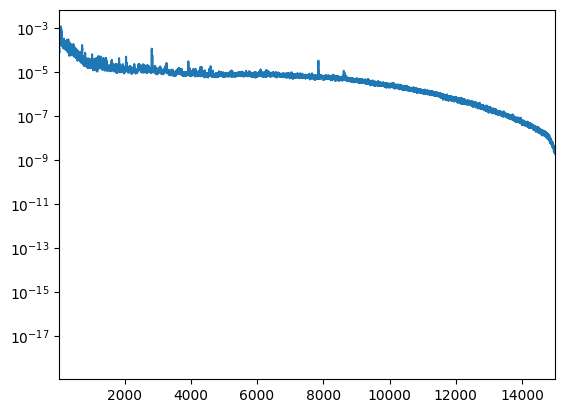

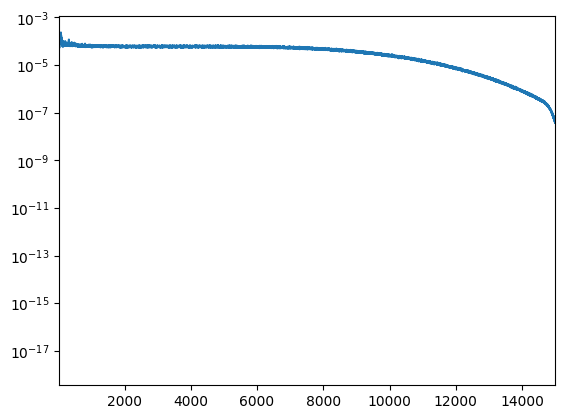

In [36]:
psd_ones_mean = np.mean(psd_ones, axis=0)
psd_zeros_mean = np.mean(psd_zeros, axis=0)

plt.semilogy(f, psd_ones_mean)
plt.xlim([30,15000])
plt.show()
plt.semilogy(f, psd_zeros_mean)
plt.xlim([30,15000])
plt.show()